In [1]:
import pandas as pd
import os
from sodapy import Socrata
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import acquire
import prepare
import explore
import wrangle

pd.set_option('display.max_column', None)
# plotting defaults
plt.rc('figure', figsize=(23, 10))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

# Acquire and Prepare the Data
We'll use the wrangle module to acquire and prepare the data in one step

In [2]:
df = wrangle.wrangle_crime_data(drop_cleared_by_exception=True)

Using cached csv


In [3]:
print(df.shape)
df.head()

(348008, 18)


,crime_type,family_violence,occurrence_time,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared,time_to_report
34573,ASSAULT ON PUBLIC SERVANT,N,2021-12-31 23:50:00,2021-12-31,2021-12-31 23:50:00,2021-12-31,COMMERCIAL / OFFICE BUILDING,111 CONGRESS AVE,78701.0,9.0,GE,3,30.263739,-97.743651,cleared by arrest,2022-01-03,True,0 days 00:00:00
34574,THEFT,N,2021-12-31 23:50:00,2021-12-31,2022-01-07 14:12:00,2022-01-07,OTHER / UNKNOWN,6936 E BEN WHITE BLVD SVRD WB,78741.0,3.0,HE,5,30.215264,-97.703019,not cleared,2022-01-10,False,6 days 14:22:00
34575,PUBLIC INTOXICATION,N,2021-12-31 23:50:00,2021-12-31,2021-12-31 23:50:00,2021-12-31,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,406 E 6TH ST,78701.0,9.0,GE,2,30.267300,-97.738857,cleared by arrest,2021-12-31,True,0 days 00:00:00
34576,DOC DISCHARGE GUN - PUB PLACE,N,2021-12-31 23:47:00,2021-12-31,2021-12-31 23:47:00,2021-12-31,RESIDENCE / HOME,1202 E ST JOHNS AVE,78752.0,4.0,ID,1,30.328049,-97.693683,not cleared,2022-01-05,False,0 days 00:00:00
34577,AGG ASLT STRANGLE/SUFFOCATE,Y,2021-12-31 23:40:00,2021-12-31,2022-01-01 00:44:00,2022-01-01,RESIDENCE / HOME,10000 N LAMAR BLVD,78758.0,4.0,ED,1,30.369262,-97.695105,not cleared,2022-01-05,False,0 days 01:04:00


# Explore the Distributions of the Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348008 entries, 34573 to 436548
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   crime_type        348008 non-null  object         
 1   family_violence   348008 non-null  object         
 2   occurrence_time   348008 non-null  datetime64[ns] 
 3   occurrence_date   348008 non-null  datetime64[ns] 
 4   report_time       348008 non-null  datetime64[ns] 
 5   report_date       348008 non-null  datetime64[ns] 
 6   location_type     348008 non-null  object         
 7   address           348008 non-null  object         
 8   zip_code          348008 non-null  float64        
 9   council_district  348008 non-null  float64        
 10  sector            348008 non-null  object         
 11  district          348008 non-null  object         
 12  latitude          348008 non-null  float64        
 13  longitude         348008 non-null  float

In [5]:
# Use .describe with object columns
obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]
obj_cols

for col in obj_cols:
    print(col.upper())
    print('Count:')
    print(df[col].value_counts())
    print('\n')
    print('Proportions:')
    print(df[col].value_counts(normalize=True, dropna=False))
    print('--------------------------')
    print('\n')


CRIME_TYPE
Count:
BURGLARY OF VEHICLE                            34866
THEFT                                          29886
FAMILY DISTURBANCE                             24369
CRIMINAL MISCHIEF                              19334
AUTO THEFT                                     12766
                                               ...  
EXPIRED-DO NOT USE-ASSAULT ON PEACE OFFICER        1
ATT BURGLARY OF RESIDENCE                          1
ABUSE OF CORPSE                                    1
COMMERCIAL BRIBERY                                 1
BAIL JUMPING/FAIL TO APPEAR                        1
Name: crime_type, Length: 340, dtype: int64


Proportions:
BURGLARY OF VEHICLE                            0.100187
THEFT                                          0.085877
FAMILY DISTURBANCE                             0.070024
CRIMINAL MISCHIEF                              0.055556
AUTO THEFT                                     0.036683
                                                 ...   
EXPI

In [6]:
df.council_district.value_counts()

9.0     56210
3.0     51470
4.0     48454
7.0     39783
1.0     39405
2.0     33079
5.0     28316
6.0     20450
10.0    16077
8.0     14764
Name: council_district, dtype: int64

# Split the Data for Exploratation

In [7]:
train, validate, test = prepare.split_data(df)
train.shape, validate.shape, test.shape

((194884, 18), (83522, 18), (69602, 18))

In [8]:
train_copy = train.copy()

# Copy of Train and adding GeoPandas

In [9]:
#Assign my .shp file to a variable named “asutin_map”
austin_map = gpd.read_file('Boundaries_zipcode/geo_export_9b5aa23d-57b1-41f4-b4f9-0a9d97fac540.shp')

In [10]:
austin_map = austin_map.drop(columns =['affgeoid10','geoid10','aland10','awater10'])

In [11]:
austin_map = austin_map.rename(columns ={'zcta5ce10': 'zip_code'})
austin_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zip_code  54 non-null     object  
 1   geometry  54 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 992.0+ bytes


In [12]:
austin_map['zip_code'] = austin_map.zip_code.astype('float64')

In [13]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194884 entries, 229881 to 160882
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   crime_type        194884 non-null  object         
 1   family_violence   194884 non-null  object         
 2   occurrence_time   194884 non-null  datetime64[ns] 
 3   occurrence_date   194884 non-null  datetime64[ns] 
 4   report_time       194884 non-null  datetime64[ns] 
 5   report_date       194884 non-null  datetime64[ns] 
 6   location_type     194884 non-null  object         
 7   address           194884 non-null  object         
 8   zip_code          194884 non-null  float64        
 9   council_district  194884 non-null  float64        
 10  sector            194884 non-null  object         
 11  district          194884 non-null  object         
 12  latitude          194884 non-null  float64        
 13  longitude         194884 non-null  floa

In [14]:
#create a new dataframe with both our geographical and statistical data in it by merging our two tables together.
new_df = austin_map.merge(train_copy, on ='zip_code')

In [15]:
new_df.to_csv('Geo_Crime_Reports.csv')

In [16]:
new_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 194879 entries, 0 to 194878
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   zip_code          194879 non-null  float64        
 1   geometry          194879 non-null  geometry       
 2   crime_type        194879 non-null  object         
 3   family_violence   194879 non-null  object         
 4   occurrence_time   194879 non-null  datetime64[ns] 
 5   occurrence_date   194879 non-null  datetime64[ns] 
 6   report_time       194879 non-null  datetime64[ns] 
 7   report_date       194879 non-null  datetime64[ns] 
 8   location_type     194879 non-null  object         
 9   address           194879 non-null  object         
 10  council_district  194879 non-null  float64        
 11  sector            194879 non-null  object         
 12  district          194879 non-null  object         
 13  latitude          194879 non-null  f

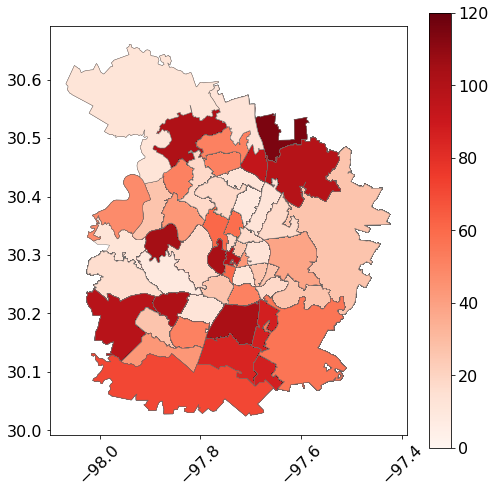

In [17]:
#Crime_type by zip_code
fig, ax = plt.subplots(1, figsize=(8, 8))
plt.xticks(rotation=45)
new_df.plot(column="crime_type", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")
bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=120))
bar_info._A = []
cbar = fig.colorbar(bar_info)

# Continuing exploration on Train

In [18]:
train[train.crime_type == 'PUBLIC INTOXICATION'].council_district.value_counts()

9.0     655
3.0     329
4.0     246
7.0     217
1.0     191
5.0     120
2.0     118
6.0      86
10.0     60
8.0      36
Name: council_district, dtype: int64

In [19]:
train[train.family_violence == 'True'].cleared.value_counts()

Series([], Name: cleared, dtype: int64)

## crime type exploration

- murders - 85 total, 8 capital murders in set the rest are murders
- 2061 public intoxications
- 15.5k family violence reports

In [20]:
train.family_violence.value_counts()

N    179322
Y     15562
Name: family_violence, dtype: int64

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194884 entries, 229881 to 160882
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   crime_type        194884 non-null  object         
 1   family_violence   194884 non-null  object         
 2   occurrence_time   194884 non-null  datetime64[ns] 
 3   occurrence_date   194884 non-null  datetime64[ns] 
 4   report_time       194884 non-null  datetime64[ns] 
 5   report_date       194884 non-null  datetime64[ns] 
 6   location_type     194884 non-null  object         
 7   address           194884 non-null  object         
 8   zip_code          194884 non-null  float64        
 9   council_district  194884 non-null  float64        
 10  sector            194884 non-null  object         
 11  district          194884 non-null  object         
 12  latitude          194884 non-null  float64        
 13  longitude         194884 non-null  floa

In [22]:
train.council_district.value_counts()

9.0     31425
3.0     28882
4.0     27091
7.0     22339
1.0     21931
2.0     18517
5.0     15924
6.0     11488
10.0     9033
8.0      8254
Name: council_district, dtype: int64

### General takeaways
- total of 195K rows of crime
- district 9 has highest count at 31k
    - UT campus, 6th Street, Rainey Street, capital
- district 3/4 have roughly the same at 28k
    - district 3 - ladybird lake, ACC
- district 7/1 have 22k each of crime
- district 2/5 have about 17k
- district 6/10/8 have the lowest counts by far
    - 'west' austin, more on the outskirts
    - district 8 - zilker park, barton springs pool
    - district 10 - lake travis, westlake
    - district 6 - borders cedar park
    
- Seasonality
- SXSW - March
- ACL - October
- School - STARTS late August | ENDS Early December
            STARTS early January | ENDS Late May


#### What kind of crime is in each district?

In [23]:
train.council_district.value_counts()

9.0     31425
3.0     28882
4.0     27091
7.0     22339
1.0     21931
2.0     18517
5.0     15924
6.0     11488
10.0     9033
8.0      8254
Name: council_district, dtype: int64

In [24]:
one = train[train.council_district == 1]
two = train[train.council_district == 2]
three = train[train.council_district == 3]
four = train[train.council_district == 4]
five = train[train.council_district == 5]
six = train[train.council_district == 6]
seven = train[train.council_district == 7]
eight = train[train.council_district == 8]
nine = train[train.council_district == 9]
ten = train[train.council_district == 10]


one.shape, two.shape, three.shape, four.shape, five.shape, six.shape, seven.shape, eight.shape, nine.shape, ten.shape

((21931, 18),
 (18517, 18),
 (28882, 18),
 (27091, 18),
 (15924, 18),
 (11488, 18),
 (22339, 18),
 (8254, 18),
 (31425, 18),
 (9033, 18))

In [25]:
# district 9 has the most crime
nine.crime_type.value_counts()

THEFT                             3079
BURGLARY OF VEHICLE               3010
CRIMINAL MISCHIEF                 1673
ASSAULT BY CONTACT                1656
ASSAULT WITH INJURY               1414
                                  ... 
ASSAULT OF A PREGNANT WOMAN          1
DOC WINDOW PEEPING - PUB AREA        1
MANF CONTROLLED SUB- SYN NARC        1
UNLAWFUL RESTRAINT FAM/DAT VIO       1
UNLAWFUL INTERCEPTION                1
Name: crime_type, Length: 258, dtype: int64

In [26]:
# district 3 is also in downtown, looking at the crime type
three.crime_type.value_counts()

THEFT                             2594
BURGLARY OF VEHICLE               2532
FAMILY DISTURBANCE                1993
CRIMINAL MISCHIEF                 1542
AUTO THEFT                        1118
                                  ... 
VOCO SOLICITATION PROHIBIT           1
KEEPING GAMBLING PLACE               1
DISRUPTING MEETING/PROCESSION        1
POCKET PICKING                       1
TELECOMMUNICATION CRIMES/OTHER       1
Name: crime_type, Length: 238, dtype: int64

In [27]:
# district 8 is west austin, looking at crime type
eight.crime_type.value_counts()

BURGLARY OF VEHICLE               1181
THEFT                              882
FAMILY DISTURBANCE                 395
THEFT BY SHOPLIFTING               348
CRIMINAL MISCHIEF                  348
                                  ... 
POSS OF ALCOHOL-AGE 16 & UNDER       1
PROBATION VIOL                       1
HINDERING APPREHENSION               1
HARBORING RUNAWAY CHILD              1
VIOL CITY ORDINANCE - SOUND          1
Name: crime_type, Length: 185, dtype: int64

In [28]:
# district 10 is more closer to lake travis, second lowest crime count
ten.crime_type.value_counts()

BURGLARY OF VEHICLE              1783
THEFT                             723
CRIMINAL MISCHIEF                 487
FAMILY DISTURBANCE                476
HARASSMENT                        375
                                 ... 
CRASH/CRIM NEG HOMICIDE             1
UCW LICENSE PREMISE                 1
DOC WINDOW PEEPING - PUB AREA       1
INHALANT ABUSE                      1
MANF CONTROLLED SUB - OTHER         1
Name: crime_type, Length: 187, dtype: int64

## Districts and their level of crime in descending order
### Questions for Ryan
- What does it mean for the case to not be cleared
-- not cleared means charge has not been given yet. not enough evidence to be charged
-- cleared by exception doesn't mean it was ended in arrest. person could have died
-- cleared by arrest
- Did he notice seasonality trends
- pre/post covid numbers
-- family violence pre and post pandemic
-- what days are higher in family violence
- single incident top charge
-- 

In [29]:
train.groupby('family_violence').crime_type.value_counts()

family_violence  crime_type                    
N                BURGLARY OF VEHICLE               19455
                 THEFT                             16622
                 FAMILY DISTURBANCE                13661
                 CRIMINAL MISCHIEF                 10821
                 AUTO THEFT                         7204
                                                   ...  
Y                KIDNAPPING FAM VIO                    1
                 MANSLAUGHTER                          1
                 PUBLIC INTOXICATION                   1
                 ROBBERY BY THREAT                     1
                 VIOL OF EMERG PROTECTIVE ORDER        1
Name: crime_type, Length: 390, dtype: int64

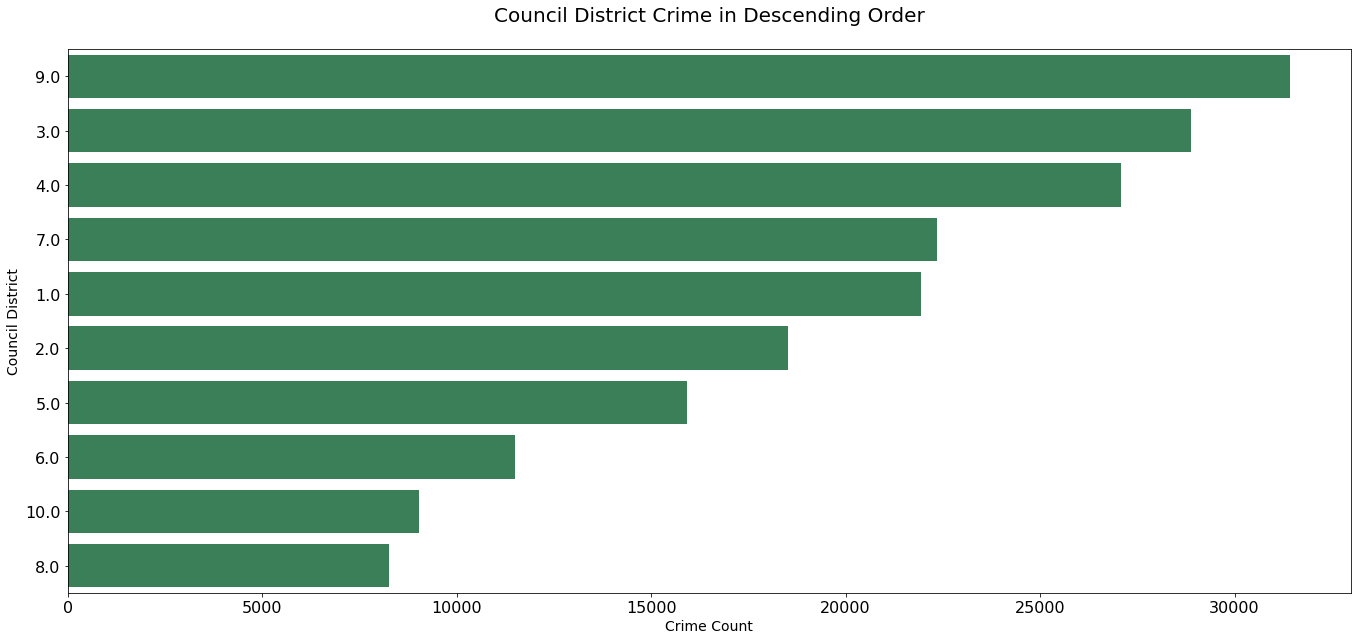

In [30]:
def council_district_crime(train):
    '''
    This function will take in the train dataset and return a seaborn 
    visual of the council district and their crime count in descending order
    '''
    ax = sns.countplot(data = train, y = 'council_district',order = train['council_district'].value_counts(ascending = False).index, color = 'seagreen')
    plt.xlabel('Crime Count',fontsize=14)# set up the x axis. 
    plt.ylabel('Council District',fontsize=14)# set up the y axis
    plt.title('Council District Crime in Descending Order\n',fontsize=20) # set up the title.
    plt.show()

    return

council_district_crime(train)

In [31]:
train.district.value_counts()

2     38747
1     36404
3     23969
4     23444
5     19789
7     19460
6     18550
8     13259
S       537
88      359
D       193
B        69
A        44
P        42
C        18
Name: district, dtype: int64

In [32]:
def district_crime(train):
    """
    This function is to create a visual to show all districts in descending order. 
    """
    # creating district crime frequency (horizontal)

    train.district.value_counts(ascending = True, normalize = False).plot.barh(color = 'orange',figsize = (12, 7))
    # adding title
    plt.xlabel('Crime Count',fontsize=12)# set up the x axis. 
    plt.ylabel('District',fontsize=12)# set up the y axis
    plt.title('District Crime in Descending Order\n',fontsize=15) # set up the title.
    plt.show()


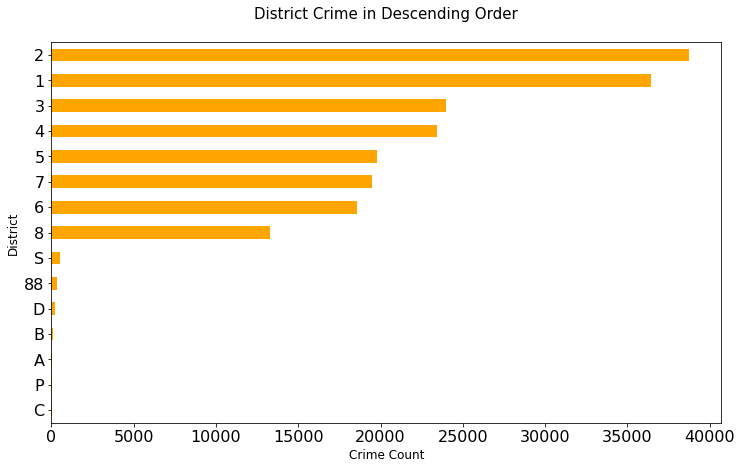

In [33]:
district_crime(train)

In [34]:
train[train.crime_type == 'MURDER'].value_counts().sum()

73

In [35]:
train.groupby('district').cleared.value_counts()

district  cleared
1         False      28430
          True        7974
2         False      28802
          True        9945
3         False      19205
          True        4764
4         False      18659
          True        4785
5         False      15886
          True        3903
6         False      15249
          True        3301
7         False      16323
          True        3137
8         False      10824
          True        2435
88        False        225
          True         134
A         False         34
          True          10
B         False         56
          True          13
C         False         16
          True           2
D         False        168
          True          25
P         False         36
          True           6
S         False        410
          True         127
Name: cleared, dtype: int64

In [36]:
top_10_crimes = ['DWI', 'ASSAULT WITH INJURY', 'THEFT BY SHOPLIFTING', 'HARASSMENT', 
                 'AUTO THEFT', 'ASSAULT W/INJURY-FAM/DATE VIOL', 'CRIMINAL MISCHIEF', 
                 'FAMILY DISTURBANCE', 'THEFT', 'BURGLARY OF VEHICLE']
# Create a subsetted df that only includes the top 10 crimes
top_crimes_df = train.copy()
top_crimes_df = top_crimes_df[top_crimes_df.crime_type.isin(top_10_crimes)]

In [37]:
def top_crime(top_crimes_df):
    """
    This function is to create a visual to show all districts in descending order. 
    """
    # creating district crime frequency (horizontal)

    top_crimes_df.council_district.value_counts(ascending = True, normalize = False).plot.barh(color = 'blue',figsize = (12, 7))
    # adding title
    plt.xlabel('Crime Count',fontsize=12)# set up the x axis. 
    plt.ylabel('Council District',fontsize=12)# set up the y axis
    plt.title('Council District Crime in Descending Order\n',fontsize=15) # set up the title.
    plt.show()

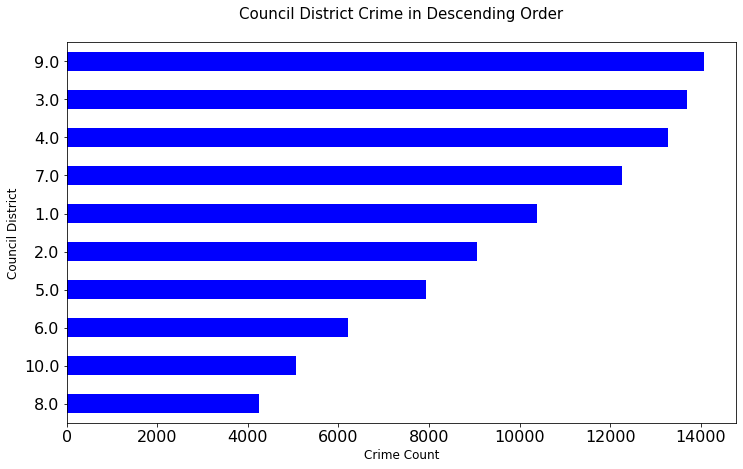

In [38]:
top_crime(top_crimes_df)

### Takeaway
- It seems that districts 9, 3 and 4 are much higher in crime compared to the other districts

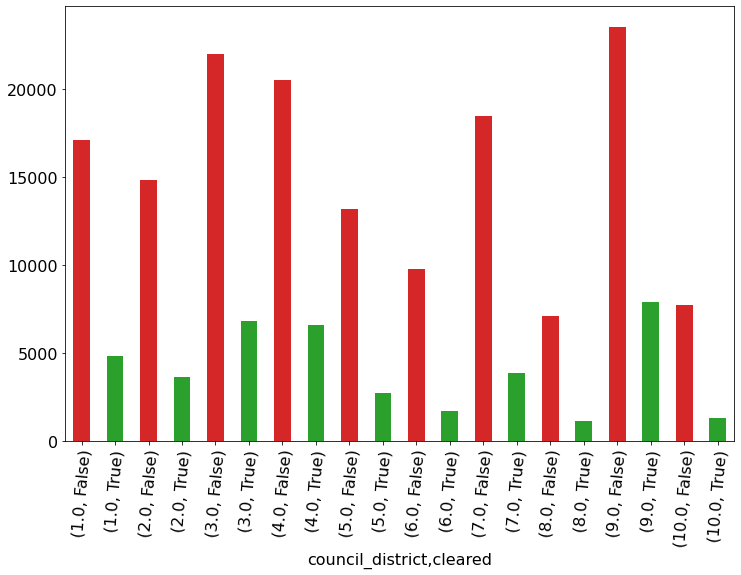

In [39]:
train.groupby('council_district').cleared.value_counts().plot.bar(figsize = (12, 8), color = ['#d62728', '#2ca02c'])
plt.tick_params('x' ,rotation = 85)

In [40]:
train.head()

,crime_type,family_violence,occurrence_time,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared,time_to_report
229881,FAMILY DISTURBANCE,N,2019-12-27 23:14:00,2019-12-27,2019-12-27 23:14:00,2019-12-27,RESIDENCE / HOME,5800 TECHNI CENTER DR,78721.0,1.0,CH,5,30.278777,-97.671951,not cleared,2020-01-08,False,0 days 00:00:00
131423,ASSAULT W/INJURY-FAM/DATE VIOL,Y,2020-12-17 21:18:00,2020-12-17,2020-12-17 21:18:00,2020-12-17,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,8601 RESEARCH BLVD SVRD NB,78758.0,4.0,ED,2,30.362560,-97.715688,not cleared,2020-12-21,False,0 days 00:00:00
362058,CRUELTY TO ANIMALS,N,2018-09-26 13:17:00,2018-09-26,2018-09-26 13:17:00,2018-09-26,RESIDENCE / HOME,2312 RACHAEL CT,78748.0,5.0,FR,1,30.177874,-97.828377,not cleared,2018-09-27,False,0 days 00:00:00
343230,AGG ASSAULT FAM/DATE VIOLENCE,Y,2018-12-01 19:31:00,2018-12-01,2018-12-01 19:31:00,2018-12-01,RESIDENCE / HOME,4810 SINGLE SHOT CIR,78723.0,1.0,CH,4,30.291001,-97.676904,not cleared,2018-12-06,False,0 days 00:00:00
145220,BURGLARY OF VEH-NO SUSPECT/FU,N,2020-10-30 15:30:00,2020-10-30,2020-10-30 16:57:00,2020-10-30,RESIDENCE / HOME,1600 MUSKET VALLEY TRL,78754.0,1.0,ED,5,30.374472,-97.655692,not cleared,2020-11-02,False,0 days 01:27:00


In [41]:
def lower_zipcode_crime(train):
    """
    This function is to create a visual to show all districts in descending order. 
    """
    # creating district crime frequency (horizontal)

    train.zip_code.value_counts(ascending = True, normalize = False).tail(10).plot.barh(color = 'red',figsize = (12, 7))
    # adding title
    plt.xlabel('Crime Count',fontsize=12)# set up the x axis. 
    plt.ylabel('Zipcode',fontsize=12)# set up the y axis
    plt.title('Highest Reported Zipcodes\n',fontsize=15) # set up the title.
    plt.show()

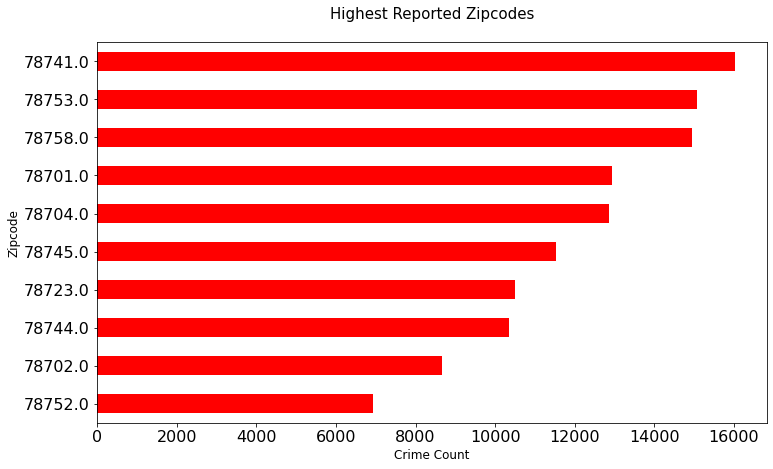

In [42]:
lower_zipcode_crime(train)

In [43]:
def upper_zipcode_crime(train):
    """
    This function is to create a visual to show top 10 safest zipcodes in descending order. 
    """
    # creating district crime frequency (horizontal)

    train.zip_code.value_counts(ascending = True, normalize = False).head(10).plot.barh(color = 'green',figsize = (12, 7))
    # adding title
    plt.xlabel('Crime Count',fontsize=12)# set up the x axis. 
    plt.ylabel('Zipcode',fontsize=12)# set up the y axis
    plt.title('Least Reported Zipcodes\n',fontsize=15) # set up the title.
    plt.show()

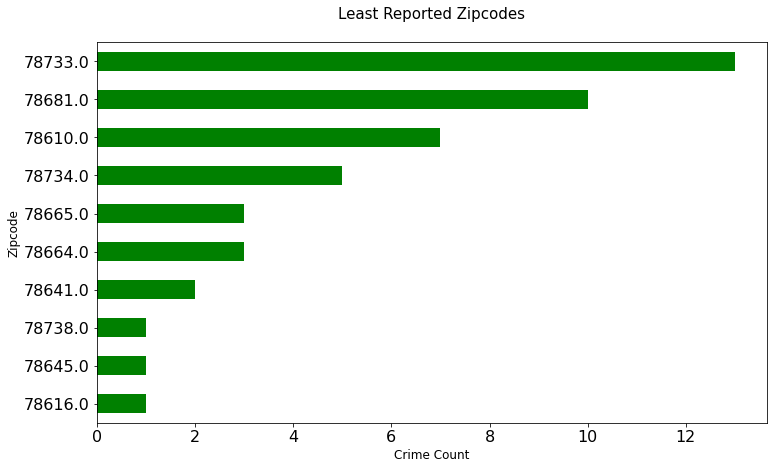

In [44]:
upper_zipcode_crime(train)

<AxesSubplot:xlabel='council_district'>

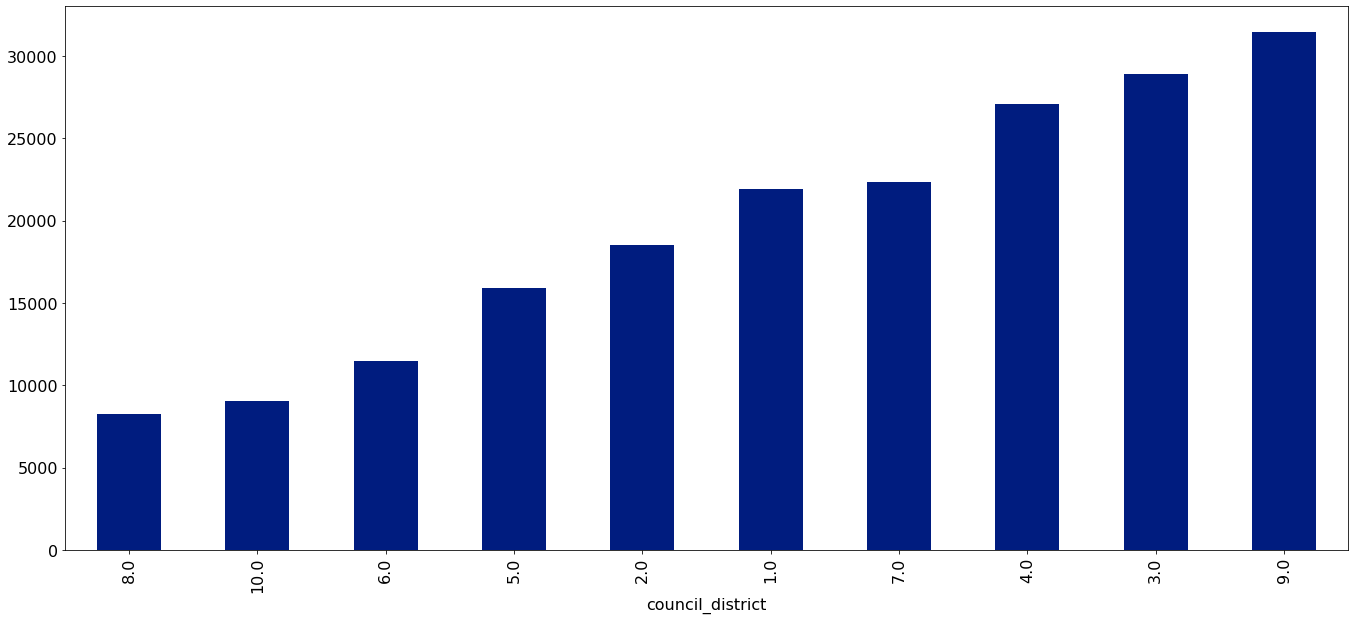

In [45]:
train.groupby(train.council_district).crime_type.count().sort_values().plot.bar()

hard to solve
- family disturbance
- disturbance


more solvable
- auto theft (possible)
- assault with injury
- dwi
- 

topics of discussion
- hardening targets ( proper lighting, dog in yard )

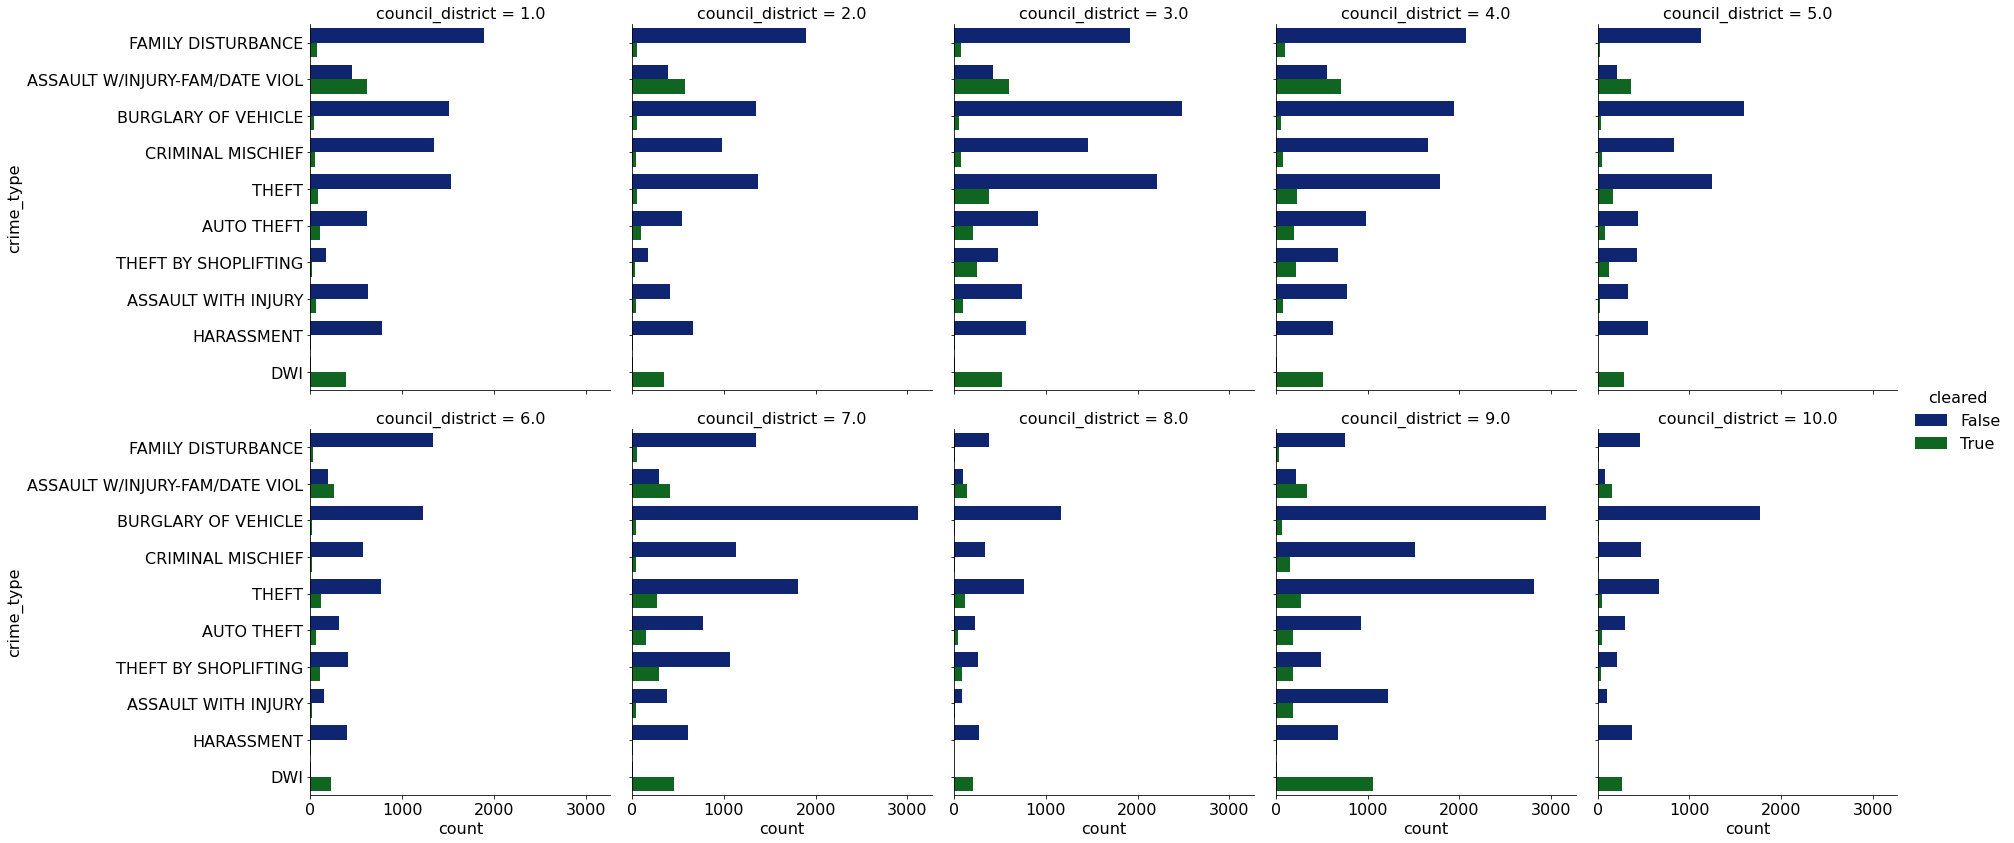

In [46]:
#define plotting region (2 rows, 5 columns)
# fig, axes = plt.subplots(2, 5)

sns.catplot(y="crime_type", hue="cleared", col="council_district",
              data=top_crimes_df, kind="count",
                height=6, aspect=.9, col_wrap = 5);


In [47]:
train.groupby('council_district').cleared.value_counts()

council_district  cleared
1.0               False      17100
                  True        4831
2.0               False      14865
                  True        3652
3.0               False      22024
                  True        6858
4.0               False      20504
                  True        6587
5.0               False      13214
                  True        2710
6.0               False       9783
                  True        1705
7.0               False      18455
                  True        3884
8.0               False       7103
                  True        1151
9.0               False      23540
                  True        7885
10.0              False       7735
                  True        1298
Name: cleared, dtype: int64

In [48]:
train.cleared.mean()

0.2081289382401839

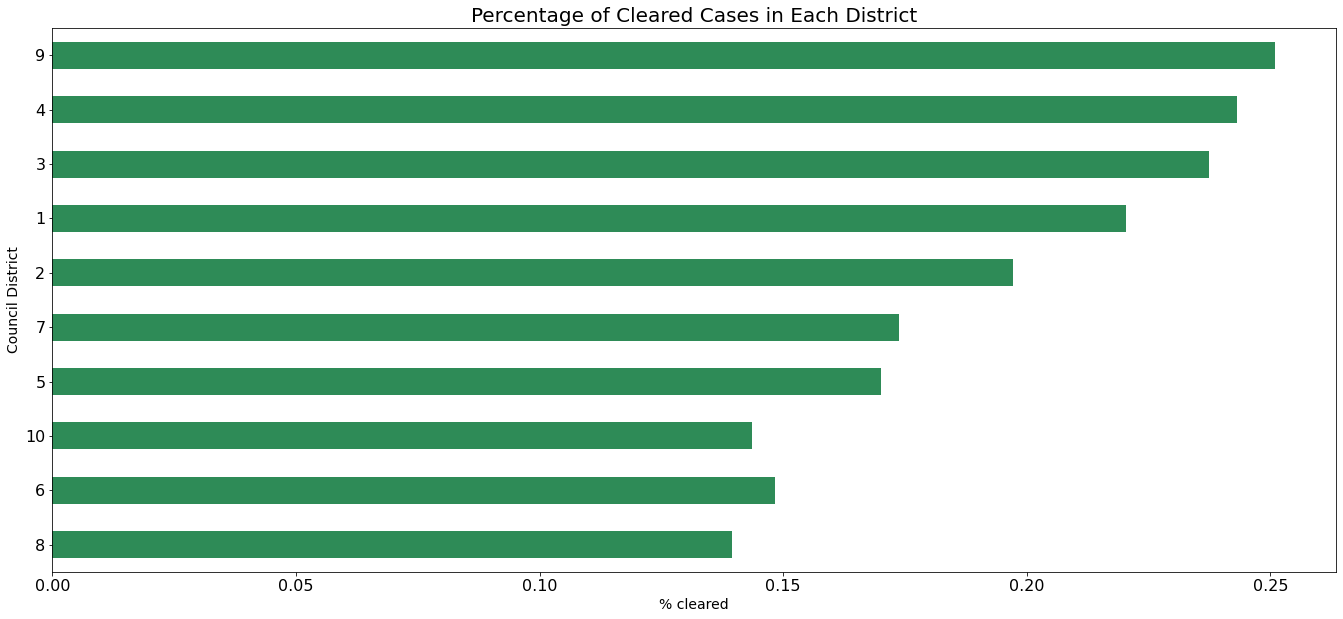

In [49]:
def district_cleared(train):
    index = [8,6,10,5,7,2,1,3,4,9]
    df1 = pd.DataFrame(train.groupby('council_district').cleared.mean(), index = index)
    ax = df1.plot.barh(color = 'seagreen')
    plt.ylabel('Council District', fontsize = 14)
    plt.xlabel('% cleared', fontsize = 14)
    plt.title('Percentage of Cleared Cases in Each District', fontsize = 20)
    ax.get_legend().remove()
    return 
district_cleared(train)

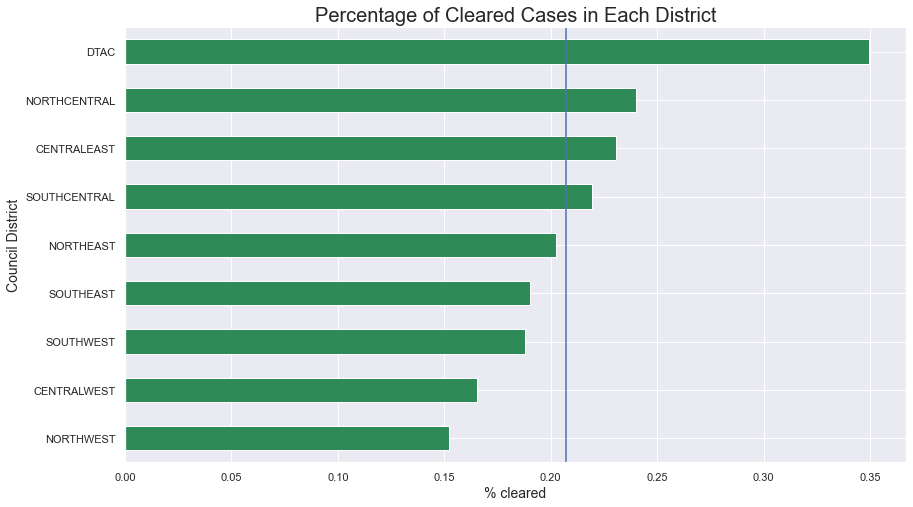

In [130]:
def patrol_area_cleared(train1):
    
    df1 = pd.DataFrame(train1.groupby('patrol_area').cleared.mean().sort_values())
    ax = df1.plot.barh(color = 'seagreen')
    plt.ylabel('Council District', fontsize = 14)
    plt.xlabel('% cleared', fontsize = 14)
    plt.title('Percentage of Cleared Cases in Each District', fontsize = 20)
    ax.get_legend().remove()
    ax.axvline(train1.cleared.mean())
    return 
patrol_area_cleared(train1)

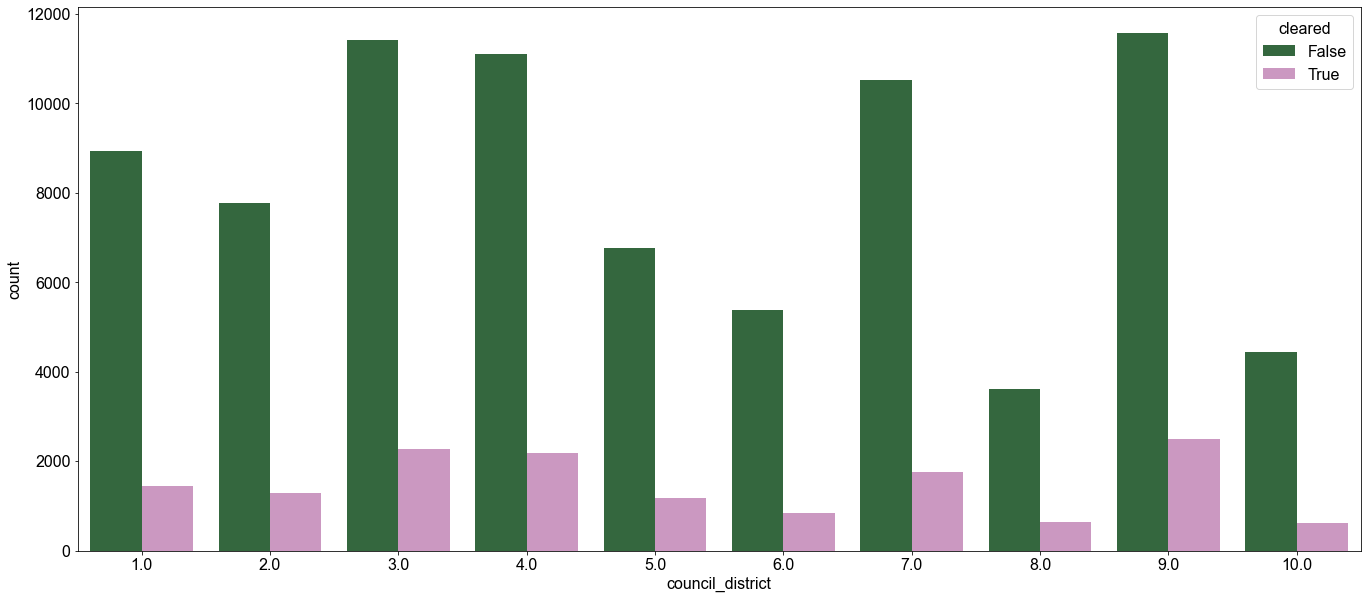

In [50]:
def top_crime_per_district_cleared(train):
    sns.countplot(data = top_crimes_df, x = 'council_district', hue = 'cleared', palette = 'cubehelix')
    sns.set(rc={'figure.figsize':(14, 8)})
    return
top_crime_per_district_cleared(train)

In [51]:
overall_sample = train.groupby('council_district').council_district.count().mean()
nine_sample = train[train.council_district == 9].count()
eight_sample = train[train.council_district == 8].count()
overall_sample, nine_sample, eight_sample

(19488.4,
 crime_type          31425
 family_violence     31425
 occurrence_time     31425
 occurrence_date     31425
 report_time         31425
 report_date         31425
 location_type       31425
 address             31425
 zip_code            31425
 council_district    31425
 sector              31425
 district            31425
 latitude            31425
 longitude           31425
 clearance_status    31425
 clearance_date      31425
 cleared             31425
 time_to_report      31425
 dtype: int64,
 crime_type          8254
 family_violence     8254
 occurrence_time     8254
 occurrence_date     8254
 report_time         8254
 report_date         8254
 location_type       8254
 address             8254
 zip_code            8254
 council_district    8254
 sector              8254
 district            8254
 latitude            8254
 longitude           8254
 clearance_status    8254
 clearance_date      8254
 cleared             8254
 time_to_report      8254
 dtype: int64)

### District 9 one sample ttest

- H0: The average caseload in District 9 <= The average caseload of cases of ALL Districts
- Ha: The average caseload in District 9 > The average caseload of cases of ALL Districts

In [52]:
alpha = .05
t, p = stats.ttest_1samp(nine_sample, overall_sample)

print(t, p/2, alpha)

inf 0.0 0.05


In [53]:
if p/2 > alpha:
    print("We fail to reject Null Hypothesis")
elif t < 0:
    print("We fail to reject Null Hypothesis")
else:
    print("We reject Null Hypothesis")

We reject Null Hypothesis


### District 8 one sample ttest

- H0: The average caseload in District 8 >= The average caseload of cases of ALL Districts
- Ha: The average caseload in District 8 < The average caseload of cases of ALL Districts

In [54]:
alpha = .05
t, p = stats.ttest_1samp(eight_sample, overall_sample)

print(t, p/2, alpha)

-inf 0.0 0.05


In [55]:
if p/2 > alpha:
    print("We fail to reject Null Hypothesis")
elif t > 0:
    print("We fail to reject Null Hypothesis")
else:
    print("We reject Null Hypothesis")

We reject Null Hypothesis


# Zipcodes

# Family Violence dataset

In [56]:
fv = train.copy()
fv = train[train['family_violence'] == 'Y']
fv = fv.set_index('occurrence_time').sort_index()
fv.shape

(15562, 17)

In [57]:
fv['month'] = fv.index.month_name()
fv['day'] = fv.index.day_name()
fv['year'] = fv.index.year

In [58]:
fv.head()

,crime_type,family_violence,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared,time_to_report,month,day,year
occurrence_time,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:05:00,ASSAULT W/INJURY-FAM/DATE VIOL,Y,2018-01-01,2018-01-01 00:05:00,2018-01-01,RESIDENCE / HOME,301 BRAZOS ST,78701.0,9.0,GE,3,30.265055,-97.742241,cleared by arrest,2018-01-01,True,0 days 00:00:00,January,Monday,2018
2018-01-01 01:00:00,AGG ASLT STRANGLE/SUFFOCATE,Y,2018-01-01,2018-01-06 20:18:00,2018-01-06,RESIDENCE / HOME,10610 MORADO CIR,78759.0,10.0,AD,7,30.403906,-97.752324,not cleared,2018-01-12,False,5 days 19:18:00,January,Monday,2018
2018-01-01 01:01:00,FELONY ENHANCEMENT/ASSLT W/INJ,Y,2018-01-01,2018-01-01 01:01:00,2018-01-01,RESIDENCE / HOME,2302 E WILLIAM CANNON DR,78744.0,2.0,FR,8,30.186692,-97.758146,cleared by arrest,2018-01-01,True,0 days 00:00:00,January,Monday,2018
2018-01-01 01:12:00,AGG ASSAULT FAM/DATE VIOLENCE,Y,2018-01-01,2018-01-01 02:58:00,2018-01-01,RESIDENCE / HOME,500 E ANDERSON LN SVRD WB,78753.0,4.0,ED,1,30.341535,-97.701904,cleared by arrest,2018-01-01,True,0 days 01:46:00,January,Monday,2018
2018-01-01 02:15:00,AGG ASLT STRANGLE/SUFFOCATE,Y,2018-01-01,2018-01-01 02:15:00,2018-01-01,RESIDENCE / HOME,8701 ESCARPMENT BLVD,78749.0,8.0,DA,7,30.212219,-97.875499,not cleared,2018-01-25,False,0 days 00:00:00,January,Monday,2018


In [59]:
fv[fv.clearance_status == 'not cleared'].district.value_counts()

2     1485
1     1338
4     1162
3     1148
5     1088
7      955
6      786
8      625
88      28
S        3
D        1
Name: district, dtype: int64

In [60]:
fv[fv.clearance_status == 'not cleared'].crime_type.value_counts().head(10)

ASSAULT W/INJURY-FAM/DATE VIOL    2808
HARASSMENT                        1625
ASSAULT BY CONTACT FAM/DATING     1444
ASSAULT BY THREAT FAM/DATING       426
AGG ASLT STRANGLE/SUFFOCATE        426
AGG ASSAULT FAM/DATE VIOLENCE      329
ASSAULT BY CONTACT                 284
TERRORISTIC THREAT-FAM/DAT VIO     244
ASSAULT BY THREAT                  169
ASSAULT WITH INJURY                107
Name: crime_type, dtype: int64

In [118]:
fv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15562 entries, 2018-01-01 00:05:00 to 2021-12-31 23:40:00
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   crime_type        15562 non-null  object         
 1   family_violence   15562 non-null  object         
 2   occurrence_date   15562 non-null  datetime64[ns] 
 3   report_time       15562 non-null  datetime64[ns] 
 4   report_date       15562 non-null  datetime64[ns] 
 5   location_type     15562 non-null  object         
 6   address           15562 non-null  object         
 7   zip_code          15562 non-null  float64        
 8   council_district  15562 non-null  float64        
 9   sector            15562 non-null  object         
 10  district          15562 non-null  object         
 11  latitude          15562 non-null  float64        
 12  longitude         15562 non-null  float64        
 13  clearance_status  15562 no

<AxesSubplot:>

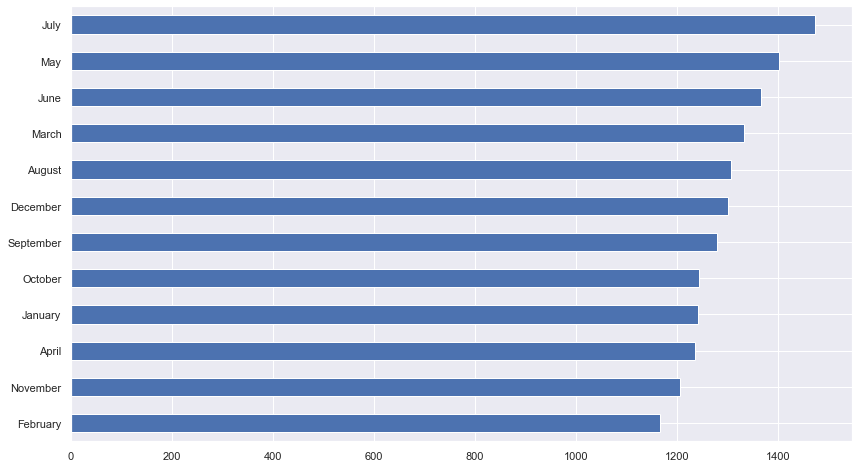

In [159]:
fv.month.value_counts().sort_values().plot.barh()

<AxesSubplot:>

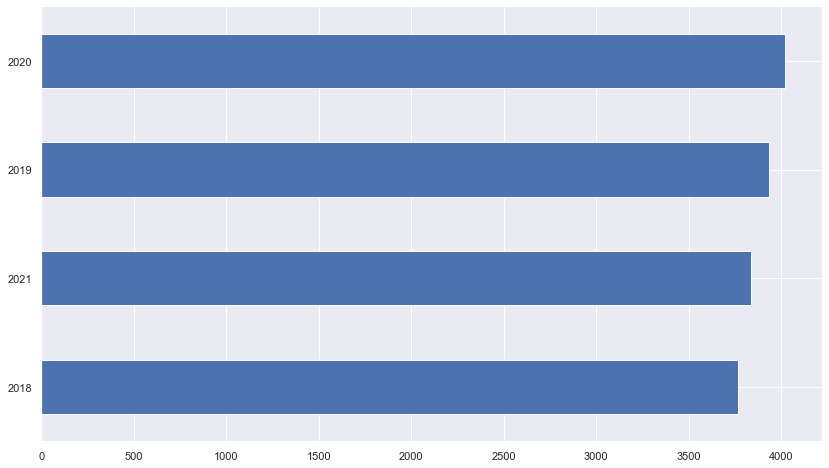

In [62]:
fv.year.value_counts().sort_values().plot.barh()

<AxesSubplot:>

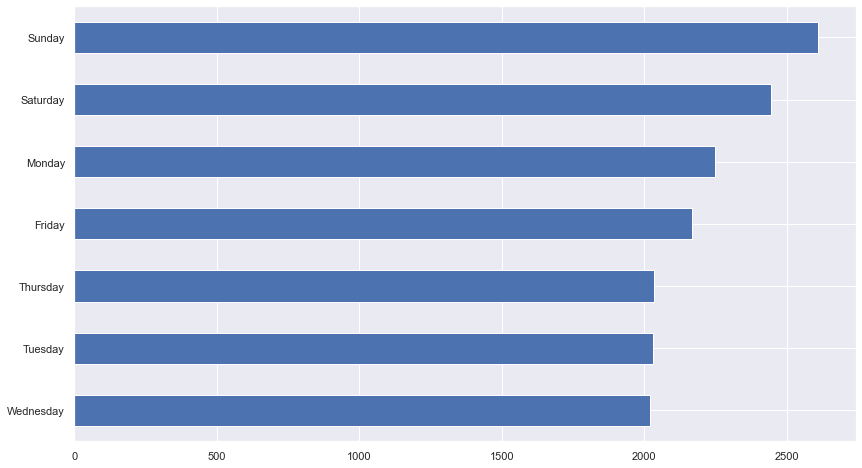

In [64]:
fv.day.value_counts().sort_values().plot.barh()

# Takeaways
- higher than average counts fall into the top 5 districts 2,1,4,3,5
- most 'not cleared' family violence crimes are assualt w/injury, harassment, assault by contact
- family violence was highest during 2020, occuring during the pandemic and lockdowns.
- Summer months have the highest reports of family violence
- Saturday and sunday have the highest occurences of family violence reports
- Monday, is the highest during the work week
-- Council Districts 4,3,1 have the highest counts of family violence

# Seasonality of clearance status


In [65]:
time_series = train.copy()
time_series= time_series.set_index('occurrence_time').sort_index()
time_series.shape

(194884, 17)

In [66]:
time_series['month'] = time_series.index.month_name()
time_series['day'] = time_series.index.day_name()
time_series['year'] = time_series.index.year

In [114]:
sns.time_series.clearance_status.

occurrence_time
2018-01-01 00:00:00          not cleared
2018-01-01 00:00:00          not cleared
2018-01-01 00:00:00          not cleared
2018-01-01 00:00:00          not cleared
2018-01-01 00:00:00          not cleared
                             ...        
2021-12-31 23:00:00          not cleared
2021-12-31 23:00:00          not cleared
2021-12-31 23:20:00          not cleared
2021-12-31 23:21:00    cleared by arrest
2021-12-31 23:40:00          not cleared
Name: clearance_status, Length: 194884, dtype: object

# District exploration
- Looking into police department district and what their clearance status looks like

In [69]:
district_data = prepare.merge_districts(df)
district_data.shape

(352931, 40)

In [70]:
train1, validate1, test1 = prepare.split_data(district_data)
train1.shape, validate1.shape, test1.shape

((197640, 40), (84704, 40), (70587, 40))

In [145]:
train2 = train1.copy()
train2 = train1.set_index('occurrence_time').sort_index()
train2.shape

(197640, 39)

In [146]:
train2['month'] = train2.index.month_name()
train2['day'] = train2.index.day_name()
train2['year'] = train2.index.year

In [147]:
train2.groupby('battalion_id').clearance_status.value_counts().sum()

197640

In [163]:
train2.head()

,crime_type,family_violence,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared,time_to_report,pd_district,the_geom,objectid,district_name,sort_order,battalion_id,jurisdiction_id,color,code,external_key,battalion_code,sector_name,input_date,modified_date,input_by,modified_by,bureau_name,patrol_area,command_phone_number,primary_key,shape_area,shape_length,month,day,year
occurrence_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,CRIMINAL MISCHIEF,N,2018-01-01,2018-01-04 16:09:00,2018-01-04,RESIDENCE / HOME,12817 SEXSON RIDGE CV,78617.0,2.0,HENRY,7,30.174692,-97.618642,not cleared,2018-01-29,False,3 days 16:09:00,HENRY 7,MULTIPOLYGON (((-97.635913438332 30.1877970633...,74,HENRY 7,1,205,59,16711808,1303,1303,H1,HENRY,12/22/2014 11:31:16 AM +0000,10/09/2018 01:44:09 PM +0000,bmartinlimuel,APD_ADMIN,SOUTH,SOUTHCENTRAL,512-974-8106,83,8.943496e+07,137659.942768,January,Monday,2018
2018-01-01,CRIMINAL MISCHIEF,N,2018-01-01,2018-04-30 19:55:00,2018-04-30,RESIDENCE / HOME,10303 NEWPORT AVE,78753.0,1.0,EDWARD,7,30.363035,-97.672449,not cleared,2018-06-22,False,119 days 19:55:00,EDWARD 7,MULTIPOLYGON (((-97.652442658383 30.3876563065...,87,EDWARD 7,1,174,13,16711680,1291,1291,E1,EDWARD,12/22/2014 11:31:16 AM +0000,10/09/2018 01:44:41 PM +0000,bmartinlimuel,APD_ADMIN,CENTRAL,NORTHEAST,512-974-5500,91,7.910069e+07,46998.269790,January,Monday,2018
2018-01-01,FRAUD - OTHER,N,2018-01-01,2018-09-01 15:53:00,2018-09-01,RESIDENCE / HOME,1716 W ST JOHNS AVE,78757.0,7.0,IDA,7,30.344482,-97.729602,not cleared,2018-09-03,False,243 days 15:53:00,IDA 7,MULTIPOLYGON (((-97.723839441668 30.3719295278...,19,IDA 7,1,215,60,16711808,1305,1305,I1,IDA,12/22/2014 11:31:16 AM +0000,09/06/2018 08:54:50 AM +0000,bmartinlimuel,AP7657,CENTRAL,NORTHCENTRAL,512-974-5203,23,9.218470e+07,43885.566418,January,Monday,2018
2018-01-01,BURGLARY NON RESIDENCE,N,2018-01-01,2019-01-04 17:42:00,2019-01-04,OTHER / UNKNOWN,8101 N LAMAR BLVD NB,78753.0,4.0,EDWARD,1,30.349433,-97.710191,not cleared,2019-02-14,False,368 days 17:42:00,EDWARD 1,MULTIPOLYGON (((-97.694118479216 30.3826672092...,57,EDWARD 1,1,174,13,16711680,1288,1288,E1,EDWARD,12/22/2014 11:31:16 AM +0000,10/09/2018 01:43:05 PM +0000,bmartinlimuel,APD_ADMIN,CENTRAL,NORTHEAST,512-974-5500,72,8.356489e+07,46296.345268,January,Monday,2018
2018-01-01,THEFT OF SERVICE,N,2018-01-01,2018-08-23 13:30:00,2018-08-23,RESIDENCE / HOME,12005 ROTHERHAM DR,78753.0,1.0,EDWARD,7,30.381374,-97.657214,not cleared,2018-10-23,False,234 days 13:30:00,EDWARD 7,MULTIPOLYGON (((-97.652442658383 30.3876563065...,87,EDWARD 7,1,174,13,16711680,1291,1291,E1,EDWARD,12/22/2014 11:31:16 AM +0000,10/09/2018 01:44:41 PM +0000,bmartinlimuel,APD_ADMIN,CENTRAL,NORTHEAST,512-974-5500,91,7.910069e+07,46998.269790,January,Monday,2018


<AxesSubplot:xlabel='council_district'>

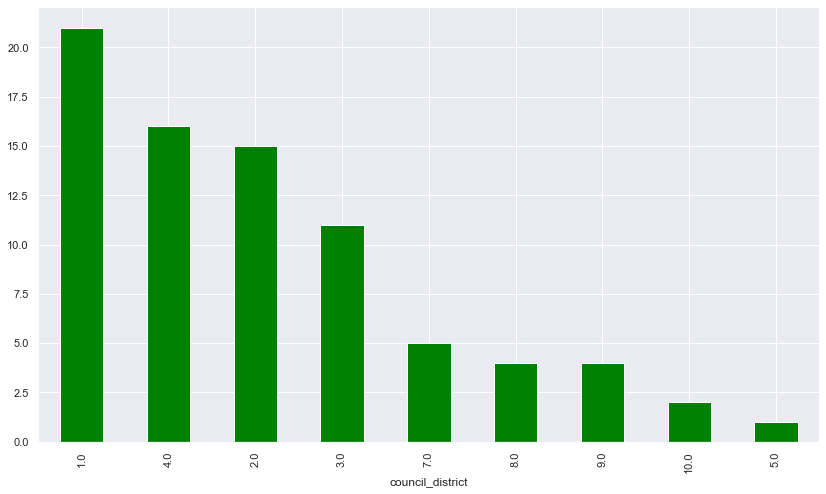

In [186]:

murder = train2[train2.crime_type.str.contains('MURDER')]

murder.groupby('council_district').crime_type.count().sort_values(ascending = False).plot.bar(color = 'green')